# Using the Nextflow and GenomeInfo outputs to examine parasite and related species' putative circular DNA

This notebook explores the outputs of the Nextflow pipeline and the `parasite_species_genomeinfo.ipynb` notebook, showing the putative circular DNA in the parasite and related species' genomes.

In [116]:
library(tidyverse)
library(data.table)
library(gggenomes)
library(arcadiathemeR)

INPUTS_LOC <- "inputs/parasite_species/"
BAM_LOC <- "results/parasite_species/bam_files/"
COV_LOC <- "results/parasite_species/coverage_files/"
GENOMEINFO_LOC <- "results/parasite_species/insert_filtered_results"

METADATA_LOC <- paste0(INPUTS_LOC, "genome_metadata.csv")

source("scripts/insert_size_funcs.R")

#### Showcasing the outputs of the GenomeInfo workflow

The merged BAM and coverage data, filtered by the insert size results in `parasite_species_genomeinfo.ipynb` is used to identify putative circular DNA. Here, we're visualizing each of the parasite and related species' coverage and mapping distances like we did with the parasitoid wasps.

In [117]:
genome_metadata <- fread(METADATA_LOC) %>%
select(taxonomy, genome_accession, average_coverage) %>%
distinct()

bam_cov_file_list <- list.files(GENOMEINFO_LOC, pattern = "_merged_bam_coverage.csv", full.names = TRUE)

In [118]:
bam_cov_dfs <- list()
for (i in bam_cov_file_list) {
    bam_cov_df <- fread(i)
    acc <- strsplit(basename(i), "_merged_bam_coverage.csv")[[1]][1]
    bam_cov_df[, genome_accession := strsplit(acc, "_vs_")[[1]][1]]
    bam_cov_df[, sra_accession := strsplit(acc, "_vs_")[[1]][2]]
    bam_cov_df[, genome_vs_sra := acc]
    # Add the df to the list
    bam_cov_dfs[[length(bam_cov_dfs) + 1]] <- bam_cov_df
}

# Put into one complete df
bam_cov_df <- rbindlist(bam_cov_dfs)
bam_cov_df[, abs_length := abs(length)] # Make all insert sizes positive

In [119]:
# Merge with the metadata
bam_cov_df <- merge(bam_cov_df, genome_metadata, by = "genome_accession")

In [121]:
for (genome_target_name in unique(bam_cov_df$taxonomy)) {
    filtered_df <- bam_cov_df[taxonomy == genome_target_name, ]
    filtered_df <- filtered_df[abs_length <= 100000,]
    filtered_df <- filtered_df[coverage > 100,]
    if (nrow(filtered_df) == 0) {
        next
    } else {
        plt <- filtered_df %>%
        ggplot(aes(abs_length / 1000, coverage)) +
        geom_point(alpha = 0.5) +
        facet_wrap(~chromosome) +
        theme_arcadia() +
        scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) +
        labs(x = "Mapped distance (kb)", y = "Coverage") +
        ggtitle(paste0(filtered_df$taxonomy[1], " - ", filtered_df$sra_accession[1], " Mapped Distance vs. Coverage"))

    outfname_png <- paste0("results/parasite_species/fig/", filtered_df$genome_vs_sra[1], "_insert_size_plot.png")
    outfname_pdf <- paste0("results/parasite_species/fig/", filtered_df$genome_vs_sra[1], "_insert_size_plot.pdf")

    ggsave(outfname_png, plt, units = "in", dpi = 300, height = 4.79 * 4, width = 4.79 * 4)
    ggsave(outfname_pdf, plt, units = "in", dpi = 300, height = 4.79 * 4, width = 4.79 * 4)
}
}

All individual species figures can be found in `results/parasite_species/fig/`. To summarize, we'll show the species, the total number of scaffolds in each species' genome assembly, and the proportion of scaffolds with large mapping distances per species.

In [ ]:
insert_summary_list <- list.files(GENOMEINFO_LOC, pattern = "deduped_insert_summary.csv", full.names = TRUE)
# Some files are empty, so they need to be removed
insert_summary_list <- insert_summary_list[sapply(insert_summary_list, function(x) nrow(read.csv(x)) > 1)]

# Load in the files, count the number of unique values in the reference_name column
# to get a count of unique scaffolds with large inserts
insert_scaffold_counts <- insert_summary_list %>% 
  map_df(~{
    file_name <- basename(.x)
    data <- read_csv(.x)
    data <- data %>% 
      summarise(n = n_distinct(reference_name))
    
    data <- data %>%
      mutate(file_name = file_name)
    })

insert_scaffold_counts <- insert_scaffold_counts %>%
  mutate(file_name = str_replace(file_name, "_deduped_insert_summary.csv", "")) %>%
  separate(file_name, c("genome_accession", "sra_accession"), sep = "_vs_") %>%
  group_by(genome_accession) %>%
  filter(n == max(n)) %>%
  select(-sra_accession) %>%
  distinct()

In [124]:
# Total scaffold counts per genome, pulled from NCBI
total_scaffold_counts <- data.frame("species" = c("Rhipicephalus microplus",
"Echinococcus multilocularis", "Ixodes scapularis", "Ixodes ricinus", "Ixodes persulcatus",
"Haemaphysalis longicornis", "Rhodnius prolixus", "Cimex lectularius", "Acanthamoeba castellanii",
"Sarcoptes scabiei", "Ornithodoros turicata", "Calliphora vomitoria", "Trichinella pseudospiralis",
"Trichinella sp. T9", "Trichinella papuae", "Trichinella zimbabwensis", "Trichinella nelsoni",
"Trichinella britovi", "Trichinella sp. T8", "Trichinella murrelli", "Trichinella patagoniensis",
"Trichinella spiralis", "Trichinella nativa", "Trichinella sp. T6", "Cochliomyia hominivorax",
"Ctenocephalides felis", "Musca domestica", "Schistosoma haematobium", "Sarcophaga peregrina"),
"genome_accession" = c("GCF_013339725.1_ASM1333972v1", 
"GCA_000469725.3_EMULTI002", "GCF_016920785.2_ASM1692078v2", "GCA_037355805.1_I.ric_WGA_PrF_JU", "GCA_013358835.2_BIME_Iper_1.3",
"GCA_013339765.2_BIME_HaeL_1.3", "GCA_000181055.3_Rhodnius_prolixus-3.0.3", "GCF_000648675.2_Clec_2.1", "GCF_000313135.1_Acastellanii.strNEFF_v1",
"GCA_020844145.1_ASM2084414v1", "GCF_037126465.1_ASM3712646v1", "GCA_942486065.2_idCalVomi1.2", "GCA_001447645.1_T4_ISS176_r1.0",
"GCA_001447505.1_T9_ISS409_r1.0", "GCA_001447755.1_T10_ISS1980_r1.0", "GCA_001447665.1_T11_ISS1029_r1.0", "GCA_001447455.1_T7_ISS37_r1.0",
"GCA_001447585.1_T3_ISS120_r1.0", "GCA_001447745.1_T8_ISS272_r1.0", "GCA_002221485.1_ASM222148v1", "GCA_001447655.1_T12_ISS2496_r1.0",
"GCF_000181795.1_Trichinella_spiralis-3.7.1", "GCA_001447565.2_T2_ISS10_r1.1", "GCA_001447435.1_T6_ISS34_r1.0", "GCA_004302925.2_ASM430292v2",
"GCF_003426905.1_ASM342690v1", "GCF_030504385.1_Musca_domestica.polishedcontigs.V.1.1", "GCF_000699445.3_UoM_Shae.V3", "GCA_014635995.1_ASM1463599v1"
),
"total_scaffolds" = c(7048,
1217, 648, 70366, 11597,
3886, 16537, 1574, 384,
9, 379, 137, 6594,
5752, 2542, 10839, 2969,
7991, 4124, 503, 6623,
6863, 2483, 5951, 522,
3733, 340, 163, 1118),
"grouping" = c("Tick species",
"Other species", "Tick species", "Tick species", "Tick species",
"Tick species", "Other species", "Other species", "Other species",
"Other species", "Tick species", "Other species", "Trichinella species",
"Trichinella species", "Trichinella species", "Trichinella species", "Trichinella species",
"Trichinella species", "Trichinella species", "Trichinella species", "Trichinella species",
"Trichinella species", "Trichinella species", "Trichinella species", "Other species",
"Other species", "Other species", "Other species", "Other species"
)
)

# Merge the two dataframes
insert_scaffold_counts <- merge(insert_scaffold_counts, total_scaffold_counts, by = "genome_accession")

write.csv(insert_scaffold_counts, "results/parasite_species/insert_filtered_results/insert_scaffold_counts.csv", row.names = FALSE)


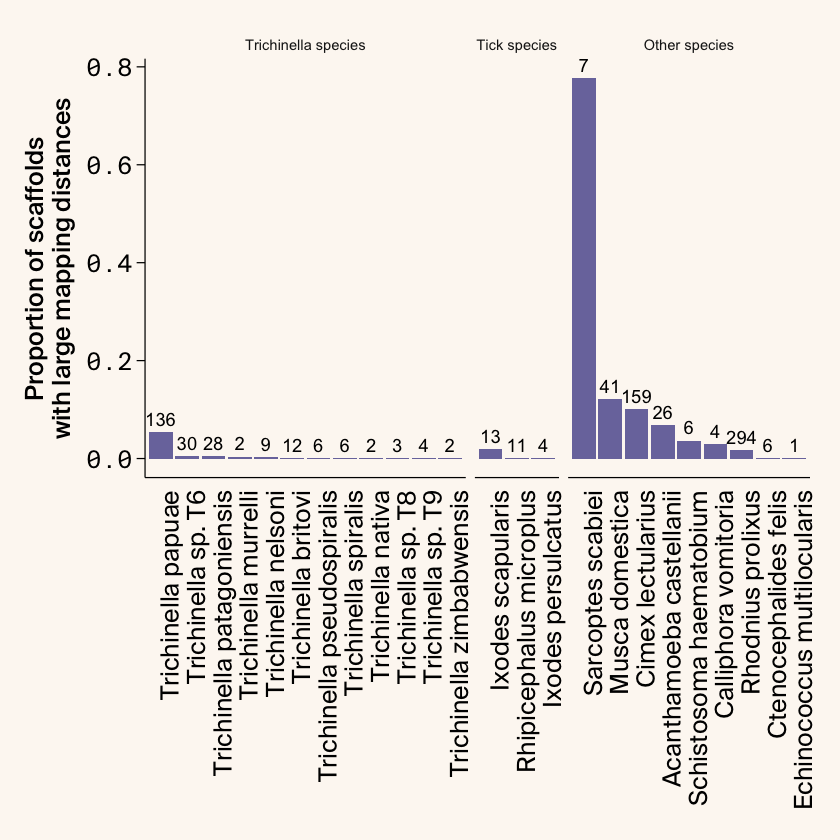

In [104]:
insert_scaffold_counts$grouping <- factor(insert_scaffold_counts$grouping, levels = c("Trichinella species", "Tick species", "Other species"))

summary_plt <- insert_scaffold_counts %>%
mutate(proportion_scaffolds = n / total_scaffolds) %>%
ggplot(aes(reorder(species, -proportion_scaffolds), proportion_scaffolds)) +
  geom_col(fill = "#7A77AB") +
  geom_text(aes(label = n), vjust = -0.5) +
  theme_arcadia(x_axis_type = "categorical") +
  facet_grid(~grouping, scales = "free_x", space = "free") +
  theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(y = "Proportion of scaffolds\nwith large mapping distances") +
  scale_fill_arcadia()

ggsave("results/parasite_species/fig/insert_size_counter.png", summary_plt, width = 9, height = 9, units = "in")
ggsave("results/parasite_species/fig/insert_size_counter.pdf", summary_plt, width = 9, height = 9, units = "in")

summary_plt

Finally, zooming in on an interesting scaffold from the _Trichinella spiralis_ genome to showcase the putative circular DNA with many DNase II copies. Exploration preceded this, searching through scaffolds with putative circular DNA.

In [108]:
# Formatting for gggenomes input, using the output of the insert size summary for a specific scaffold and insert from T spiralis
seqs <- data.frame("seq_id" = c("NW_003526940.1"), "length" = c(3447954))
feats_of_interest <- data.frame("seq_id" = c("NW_00352940.1", "NW_00352940.1", "NW_00352940.1"),
"start" = c(2522000, 2735000, 1330000),
"end" = c(2547000, 2829000, 1439000),
"type" = c("insert", "insert", "insert"),
"feat_id" = c("NW_003526940.1_i1", "NW_003526940.1_i2", "NW_003526940.1_i3"),
"width" = c(25000, 94000, 109000),
"name" = c(NA, NA, NA),
"Note" = c("Detected insert", "Detected insert", "Detected insert"),
"geom_id" = c("NW_003526940.1_i1", "NW_003526940.1_i2", "NW_003526940.1_i3"))
genes_of_interest <- read.csv(paste0(GENOMEINFO_LOC, "/GCF_000181795.1_Trichinella_spiralis-3.7.1_vs_SRR14041381_insert_filtered_gff.csv")) %>%
filter(chromosome == "NW_003526940.1") %>%
mutate(seq_id = chromosome) %>%
filter(feature == "mRNA") %>%
mutate(type = feature) %>%
mutate(product = ifelse(grepl("hypothetical", product), "", product))

Warning message:
"No matching seq_ids between feats and seqs. Maybe you are trying to add subfeats"
Showing 4 loci with the following size distribution
* min: 28686
* q25: 32243
* med: 41267
* q75: 65948
* max: 116479


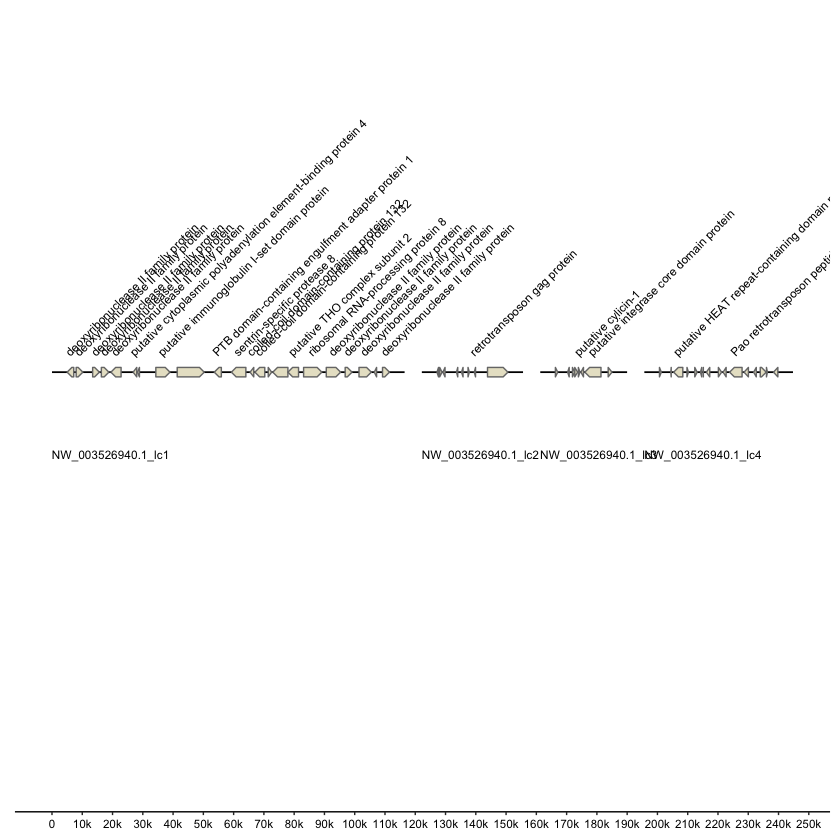

In [115]:
locus_plt <- gggenomes(feats = feats_of_interest, seqs = seqs, genes = genes_of_interest) %>%
focus(.track_id = genes) +
geom_seq() +
geom_gene() +
geom_gene_tag(aes(label = product)) +
geom_seq_label() +
scale_x_bp(breaks = seq(0, 500000, 10000))

ggsave("results/parasite_species/fig/trichinella_locus_of_interest.png", locus_plt, width = 12, height = 6, units = "in", dpi = 300)

locus_plt

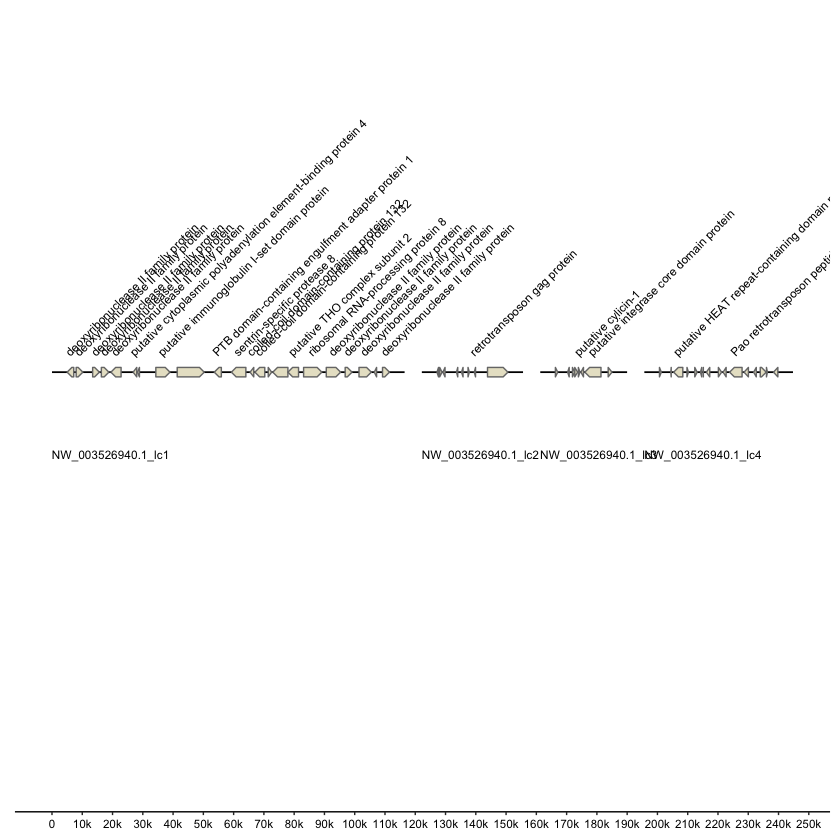